### Mounten Google Drive und Laden der Daten

In [ ]:

from google.colab import drive

drive.mount("/content/drive")



Mounted at /content/drive


In [ ]:
%pwd

'/content'

In [ ]:
%cd drive/MyDrive/PyTorch_Convnet/

/content/drive/MyDrive/PyTorch_Convnet


In [ ]:
%pwd

'/content/drive/MyDrive/PyTorch_Convnet'

In [ ]:
%ls

cifar-10-batches-py/  cifar-10-python.tar.gz  CIFAR.ipynb


In [ ]:
#!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [ ]:
#!tar -xf cifar-10-python.tar.gz

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
BATCH_SIZE = 128 #Zum Einstieg/EDA nehmen wir Batch-Size 4, nach erstem Duchlauf auf 128 gesetzt [übliche Größe]

### Feature Scaling - Normalisierung der Daten 
- Skalierung der Eingabevariablen auf kleine Werte zwischen 0 und 1
- Umfang und Störung in den Daten verringern - NN können performant nur kleine Datenwertebereiche verarbeiten
- Nicht skalierte (normalisierte) Eingabevariablen können zu einem langsamen oder instabilen Lernprozess führen, während nicht skalierte Zielvariablen bei Regressionsproblemen dazu führen können, dass Gradienten explodieren und der Lernprozess fehlschlägt.“

### Erzeugung der Pipeline
- Transformation der Bilddaten in einen Tensor
- RAUSGESTRICHEN und kommentiert unten bei lr =>Robustheit des Trainings durch Start mit kleiner Learning Rate

In [ ]:
# (x - x.mean()) / x.std() (Normalisierung) - Grund hier Deep Learning Funktionalität

transform = transforms.Compose([ # genannt Composing, wenn Bilder geladen werden, wie sollen wir sie verändert werden [1. Tensor, 2.Normalisierung]
  transforms.ToTensor(), # Umwandlung Bilder in Tensoren
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalisieren Daten (x - 0.5) / 0.5
])

### Laden der Daten und Ausgabe eines Samples des Trainsets

In [ ]:
from torch.utils.data import DataLoader

trainset = torchvision.datasets.CIFAR10(root="./", train=True, transform=transform)
trainset, devset = torch.utils.data.random_split(trainset, [45000, 5000])
dataloader = {
    "train": DataLoader(trainset, batch_size=BATCH_SIZE),
    "dev": DataLoader(devset, batch_size=BATCH_SIZE)
}
len(trainset), len(devset)

(45000, 5000)

Wie werden Daten normalisiert?
Normalisieren von Daten (x - 0.5) / 0.5
1. x - 0.5
2. ans / 0.5 #ans = Taschenrechner (das Ergebnis der ersten Subtraktion)
Denormalisieren von Daten x * 0.5 + 0.5

## EDA - Explorative Data Analysis
 - Lookup und Ausgabe Beispielbild (via Denormalisierung)
 - Konzeption eines Torch NN als Vorkonzeption der wesentlichen Parameter, Architektur
 - Erste Konzeption der Shape, des Padding, vor den eigentlichen PyTorch Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


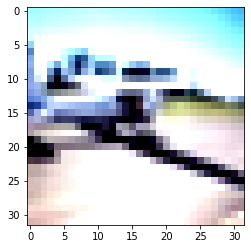

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


example_image, example_label = trainset[6]
example_image = example_image.numpy()* 0.5 + 0.5 #Denormalisierung
example_image = np.transpose(example_image, (1, 2, 0)) # Tupel mit Dimensionen (Umgestellt) in (32, 32, 3) [Höhe, Breite, Channel nach Numpy], in PyTroch oft [Channel, Höhe, Breite]
plt.imshow(example_image)

In [ ]:
example_batch = torch.rand(4, 3, 32, 32) #Batch,Channel,Breite,Höhe
example_batch.shape

torch.Size([4, 3, 32, 32])

In [ ]:
import torch.nn as nn # Convlayer zur Übung

conv = nn.Conv2d(3, 2, 3)
conv(example_batch).shape

torch.Size([4, 2, 30, 30])

In [ ]:
conv1 = nn.Conv2d(3, 6, 5, padding='same')
conv2 = nn.Conv2d(6, 9, 5, padding='same')
conv3 = nn.Conv2d(9, 6, 5, padding='same')
output = conv1(example_batch)
output = conv2(output)
output = conv3(output)
output.shape

torch.Size([4, 6, 32, 32])

## PyTorch Convolutional Model (inkl. Linear Layer)
- Convolutional 2d Layer
- MaxPooling => Robustheit Lernprozess gegenüber Schwankungen, durch Reduktion der Anzahl der Dimensionen der feature Map
- Flatten Layer => Serialisierung der Dimensionalität auf Anzahl der Elemente dieses Tensor auf Inputformat für Linear-Layer (hier 1600)
- Linear Layer
- und ReLU => activation f(x)=max(0,x) (setzt alle neg.Werte auf 0)-aktiviert nur Inputs über einem gewissen Wert (konstanter Gradient der ReLUs resultiert in schnellerem Learning)

Anmerkung: KernelSize 2 ergibt default Stride von 2 in Torch

In [ ]:
def ReLU(x): # Warum ist hier die ReLu ausgekoppelt und mehrmals angewendet unten?
    return max(0, x)

ReLU(1)

1

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1600, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.g = nn.ReLU() 
        # f(x) = max(0, x)
        # f(1) = max(0, 1) = 1
        # f(-1) = mx(0, -1) = 0
        self.dropout = nn.Dropout(p=0.2)
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.g(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.g(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.g(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.g(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

#model = Net().to(device)
model = torchvision.models.efficientnet_b0(pretrained=True)
for param in model.parameters():
    param.requires_grad = True
"""model.fc = nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 10),
)"""
model.classifier[0] = nn.Dropout(p=0.4, inplace=True)
model.classifier[1] = nn.Linear(1280, 10)
model = model.to(device)
model

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [ ]:
model(example_batch.to(device))

tensor([[-0.1008, -0.8152,  0.2021,  0.0565, -0.0224,  0.5700, -0.4201,  0.3058,
          0.0695,  0.0965],
        [-0.1045, -0.1021, -0.0775, -0.2850, -0.3868, -0.1856,  0.5620, -0.4532,
          0.0157,  0.2833],
        [ 0.3082,  0.3826, -0.0906, -0.2370, -0.4573,  0.0846, -0.0112,  0.6336,
         -0.4652, -0.3983],
        [-0.1353,  0.5469,  0.2281, -0.5138,  0.7700, -0.5427,  0.3245, -0.0136,
          0.1250, -0.3044]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Robustheit des Trainings durch Start mit kleiner Learning Rate
softmax = nn.Softmax()

for epoch in range(50):
    
    for phase in ["train", "dev"]:
        running_loss = 0.0
        running_acc = 0.0
        if phase == "train":
            model.train()
        else:
            model.eval()

        for inputs, labels in dataloader[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            acc = torch.sum(softmax(outputs).argmax(axis=1) == labels)/len(labels)

            if phase == "train":
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            running_acc += acc.item()

        mean_loss = running_loss / len(dataloader[phase])
        mean_acc = running_acc / len(dataloader[phase])
        print(f'{epoch+1} {phase} {mean_loss:.2f} {mean_acc:.2f}')

   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1 train 1.09 0.62
1 dev 0.68 0.77
2 train 0.62 0.79
2 dev 0.58 0.80
3 train 0.45 0.84
3 dev 0.57 0.82
4 train 0.36 0.87
4 dev 0.61 0.81
5 train 0.29 0.90
5 dev 0.59 0.82
6 train 0.24 0.92
6 dev 0.68 0.81
7 train 0.21 0.93
7 dev 0.67 0.82
8 train 0.18 0.94
8 dev 0.68 0.83
9 train 0.16 0.95
9 dev 0.75 0.82
10 train 0.14 0.95
10 dev 0.66 0.83
11 train 0.13 0.96
11 dev 0.73 0.83
12 train 0.11 0.96
12 dev 0.77 0.83
13 train 0.11 0.96
13 dev 0.67 0.84
14 train 0.10 0.97
14 dev 0.73 0.82
15 train 0.09 0.97
15 dev 0.70 0.84
16 train 0.08 0.97
16 dev 0.81 0.83
17 train 0.09 0.97
17 dev 0.78 0.84
18 train 0.08 0.97
18 dev 0.72 0.84
19 train 0.08 0.97
19 dev 0.76 0.83
20 train 0.07 0.98
20 dev 0.78 0.84
21 train 0.07 0.98
21 dev 0.74 0.84
22 train 0.07 0.98
22 dev 0.72 0.85
23 train 0.07 0.98
23 dev 0.81 0.84
24 train 0.06 0.98
24 dev 0.82 0.84
25 train 0.06 0.98
25 dev 0.76 0.84
26 train 0.06 0.98
26 dev 0.78 0.84
27 train 0.06 0.98
27 dev 0.75 0.84
28 train 0.06 0.98
28 dev 0.78 0.84
29 train 0

#### Nebenrechnung

In [ ]:
labels

In [ ]:
outputs

In [ ]:
softmax = nn.Softmax()
torch.sum(softmax(outputs).argmax(axis=1) == labels)/len(labels)

In [ ]:
5000 % 128